In [4]:
import _init_paths

import argparse
import os
import sys
import logging
import pprint
import cv2
from config.config import config, update_config
from utils.image import resize, transform
import numpy as np
# get config
os.environ['PYTHONUNBUFFERED'] = '1'
os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'
os.environ['MXNET_ENABLE_GPU_P2P'] = '0'
update_config('./road_train_all.yaml')

sys.path.insert(0, os.path.join('../external/mxnet', config.MXNET_VERSION))
import mxnet as mx
from core.tester import im_detect, Predictor
from symbols import *
from utils.load_model import load_param
from utils.show_boxes import show_boxes
from utils.tictoc import tic, toc
from nms.nms import py_nms_wrapper, cpu_nms_wrapper, gpu_nms_wrapper


In [15]:
# def parse_args():
#     parser = argparse.ArgumentParser(description='Show Deformable ConvNets demo')
#     # general
#     parser.add_argument('--rfcn_only', help='whether use R-FCN only (w/o Deformable ConvNets)', default=False, action='store_true')

#     args = parser.parse_args()
#     return args

# args = parse_args()

def main():
    # get symbol
    pprint.pprint(config)
    config.symbol = 'resnet_v1_101_rfcn'
    sym_instance = eval(config.symbol + '.' + config.symbol)()
    sym = sym_instance.get_symbol(config, is_train=False)

    # set up class names
    num_classes = 4
    classes = ['vehicle', 'pedestrian', 'cyclist', 'traffic lights']

    # load demo data
    test_image_path = './data/RoadImages/test/'
    image_names = ['71777.jpg', '70522.jpg', '72056.jpg', '71531.jpg', '70925.jpg', '70372.jpg', '70211.jpg']
    data = []
    for im_name in image_names:
        assert os.path.exists(test_image_path + im_name), ('%s does not exist'.format(test_image_path + im_name))
        im = cv2.imread(test_image_path + im_name, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        target_size = config.SCALES[0][1]
        max_size = config.SCALES[0][1]
        im, im_scale = resize(im, target_size, max_size, stride=config.network.IMAGE_STRIDE)
        im_tensor = transform(im, config.network.PIXEL_MEANS)
        im_info = np.array([[im_tensor.shape[2], im_tensor.shape[3], im_scale]], dtype=np.float32)
        data.append({'data': im_tensor, 'im_info': im_info})


    # get predictor
    data_names = ['data', 'im_info']
    label_names = []
    data = [[mx.nd.array(data[i][name]) for name in data_names] for i in xrange(len(data))]
    max_data_shape = [[('data', (1, 3, max([v[0] for v in config.SCALES]), max([v[1] for v in config.SCALES])))]]
    provide_data = [[(k, v.shape) for k, v in zip(data_names, data[i])] for i in xrange(len(data))]
    provide_label = [None for i in xrange(len(data))]
    arg_params, aux_params = load_param('./output/rfcn/road_obj/road_train_all/all/' +  'rfcn_road', 19 , process=True)
    predictor = Predictor(sym, data_names, label_names,
                          context=[mx.gpu(0)], max_data_shapes=max_data_shape,
                          provide_data=provide_data, provide_label=provide_label,
                          arg_params=arg_params, aux_params=aux_params)
    nms = gpu_nms_wrapper(config.TEST.NMS, 0)

    # warm up
#     for j in xrange(2):
#         data_batch = mx.io.DataBatch(data=[data[0]], label=[], pad=0, index=0,
#                                      provide_data=[[(k, v.shape) for k, v in zip(data_names, data[0])]],
#                                      provide_label=[None])
#         scales = [data_batch.data[i][1].asnumpy()[0, 2] for i in xrange(len(data_batch.data))]
#         scores, boxes, data_dict = im_detect(predictor, data_batch, data_names, scales, config)

    # test
    for idx, im_name in enumerate(image_names):
        #print('DEBUG: Image Name: {}'.format(im_name))
        data_batch = mx.io.DataBatch(data=[data[idx]], label=[], pad=0, index=idx,
                                     provide_data=[[(k, v.shape) for k, v in zip(data_names, data[idx])]],
                                     provide_label=[None])
        scales = [data_batch.data[i][1].asnumpy()[0, 2] for i in xrange(len(data_batch.data))]
        #print('DEBUG: scales: {}'.format(scales))
        tic()
        scores, boxes, data_dict = im_detect(predictor, data_batch, data_names, scales, config)
        boxes = boxes[0].astype('f')
        #print('DEBUG: boxes: {}'.format(boxes))
        scores = scores[0].astype('f')
        #print('DEBUG: scores: {}'.format(scores))
        dets_nms = []
        for j in range(1, scores.shape[1]):
            cls_scores = scores[:, j, np.newaxis]
            #print('DEBUG: cls_scores: {}'.format(cls_scores))
            cls_boxes = boxes[:, 4:8] if config.CLASS_AGNOSTIC else boxes[:, j * 4:(j + 1) * 4]
            #print('DEBUG: cls_boxes: {}'.format(cls_boxes))
            cls_dets = np.hstack((cls_boxes, cls_scores))
            #print('DEBUG: cls_dets_1: {}'.format(cls_dets))
            keep = nms(cls_dets)
            #print('DEBUG: keep: {}'.format(keep))
            cls_dets = cls_dets[keep, :]
            #print('DEBUG: cls_dets_2: {}'.format(cls_dets))
            cls_dets = cls_dets[cls_dets[:, -1] > 0.7, :]
            #print('DEBUG: cls_dets_3: {}'.format(cls_dets))
            dets_nms.append(cls_dets)
        print 'testing {} {:.4f}s'.format(im_name, toc())
        #print('DEBUG: Shape of dets_nms: {}'.format(len(dets_nms)))
        #print('DEBUG: dets_nms: {}'.format(dets_nms))
        # visualize
        im = cv2.imread(test_image_path + im_name)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        show_boxes(im, dets_nms, classes, 1)

    print 'done'



{'CLASS_AGNOSTIC': True,
 'MXNET_VERSION': 'mxnet',
 'SCALES': [(360, 640)],
 'TEST': {'BATCH_IMAGES': 1,
          'CXX_PROPOSAL': False,
          'HAS_RPN': True,
          'NMS': 0.3,
          'PROPOSAL_MIN_SIZE': 0,
          'PROPOSAL_NMS_THRESH': 0.7,
          'PROPOSAL_POST_NMS_TOP_N': 2000,
          'PROPOSAL_PRE_NMS_TOP_N': 20000,
          'RPN_MIN_SIZE': 0,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'max_per_image': 100,
          'test_epoch': 8},
 'TRAIN': {'ALTERNATE': {'RCNN_BATCH_IMAGES': 0,
                         'RPN_BATCH_IMAGES': 0,
                         'rfcn1_epoch': 0,
                         'rfcn1_lr': 0,
                         'rfcn1_lr_step': '',
                         'rfcn2_epoch': 0,
                         'rfcn2_lr': 0,
                         'rfcn2_lr_step': '',
                         'rpn1_epoch': 0,
                         'rpn1_lr': 0,
                      

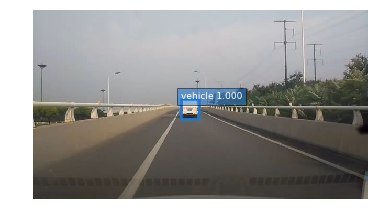

testing 70522.jpg 0.0882s


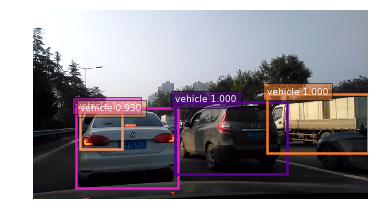

testing 72056.jpg 0.0864s


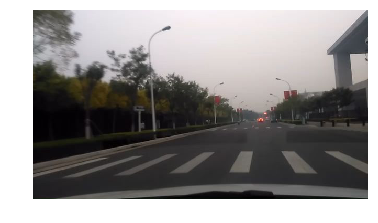

testing 71531.jpg 0.0874s


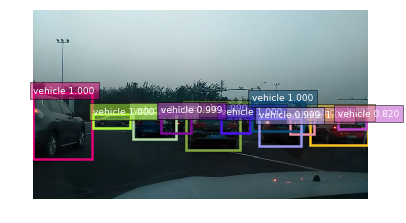

testing 70925.jpg 0.1058s


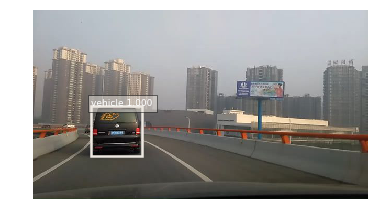

testing 70372.jpg 0.0765s


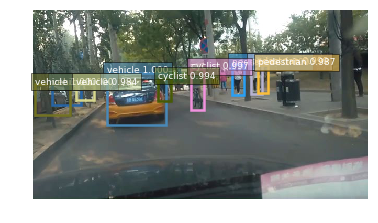

testing 70211.jpg 0.0826s


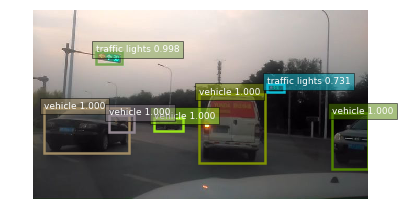

done


In [16]:
if __name__ == '__main__':
    main()
